# 다음에 볼 영화 예측하기

# Movielens 영화 SBR
- Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작

## Step 1. 데이터의 전처리
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.


### 1) Data Load

In [1]:
import datetime as dt
from pathlib import Path # pathlib =파일시스템 경로를 문자열이 아닌 객체로 다루자
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 추천시스템을 구축할 때 가장 먼저 확인(유저수(세션 수)와 아이템 수)

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 2) Session Length

In [5]:
#각 세션벼로 클릭터 데이터 확인

User_length = data.groupby('UserId').size()   # User_length : User (유저 구분자)를 공유하는 데이터 row의 개수로 분류
User_length 

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
User_length.median(), User_length.mean()

(96.0, 165.5975165562914)

In [7]:
User_length.min(), User_length.max()

(20, 2314)

In [8]:
User_length.quantile(0.999)

1343.181000000005

In [9]:
# 세션길이가 이상할때   *rows값 확인하기

long_User = User_length[User_length==200].index[0]
data[data['UserId']==long_User]

,UserId,ItemId,Rating,Time
406366,2438,908,3,974222921
406379,2438,2294,3,974222921
406412,2438,3812,5,974222921
406418,2438,3835,2,974222921
406427,2438,1186,4,974222921
...,...,...,...,...
406356,2438,3948,4,979792076
406461,2438,2502,4,981262001
406372,2438,1466,4,981322989
406413,2438,1131,5,987127691


In [10]:
# 세션길이 시각화로 분포 누적합 확인
length_count = User_length.groupby(User_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

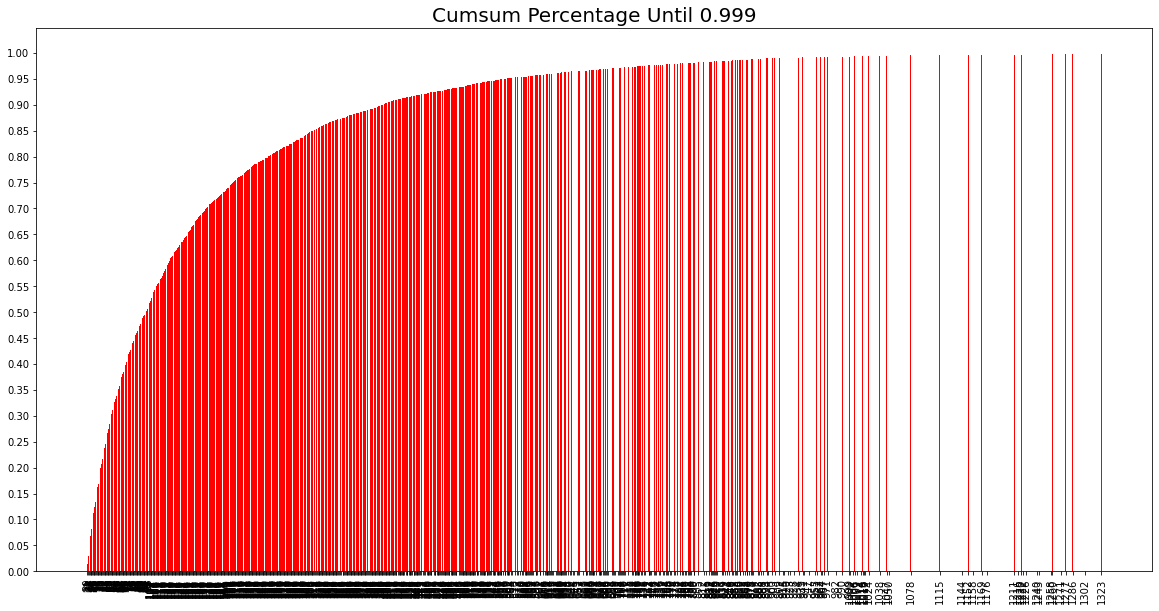

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)


plt.show()

- x축 값이 잘 보이지 않아 rotation=90 추가했더니 숫자가 보인다. 
- 라벨의 공백 삭제 시도 : plt.xticks([]), plt.yticks([]) 실패, plt.tight_layout(): 실패

### 3) Session Time
- 시간 관련 데이터 : 데이터생성, 접속하는 시간대, 접속 누적시간, 접속 요일, 계절, 마지막 접속시간, 장바구니 넣고 지난 시간

In [12]:
# 데이터의 시간 관련 정보 확인

data['Time'] = data['Time'].apply(lambda x:dt.datetime.utcfromtimestamp(int(x)))


oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)


2000-04-25 23:05:32
2003-02-28 17:49:50


- lms 노드에 나와있는대로 진행하였으나 time이 숫자 형태로만 974222921 출력되어 시간변경관련 람다식을 찾아 적용 하였다.

In [13]:
# 객체 확인

type(latest) # latest = Timestamp 객체로 확인됨, 

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
pd.to_datetime(latest, unit='s')

Timestamp('2003-02-28 17:49:50')

In [15]:
# 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용

# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data


### 4) Data Cleansing

In [16]:
# 다음 순서 예측이므로 세션 1개는 삭제

# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest) # 1) short_session을 제거
        data = cleanse_unpopular_item(data, least_click) # 2) unpopular item을 제거
        after_len = len(data)
        if before_len == after_len:
            break
    return data

# 'SessionId'  -> 'UserId' 로 변경

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


###  5) Train/ Valid/ Test split

In [18]:
#모델 평가를 위한 Valid Set과 Test Set을 만들기

test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [48]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date


In [49]:
train, test = split_by_date(data, n_days=60)
train, val = split_by_date(train, n_days=60)

In [21]:
data.sort_values(by=['Time'], inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
data.shape

(999611, 4)

In [22]:
# # data_train, data_val, data_test split

data_train = data[:700000]
data_val = data[700000:800000]
data_test = data[800000:]

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users (Sessions): {data["UserId"].nunique()}\n'  # 변경  f'\t Users (Sessions): {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
    

In [24]:
# data_train, data_val, data_test 일치화

stats_info(data_train, 'train')
stats_info(data_val, 'valid')
stats_info(data_test, 'test')

* train Set Stats Info
	 Events: 700000
	 Users (Sessions): 4870
	 Items: 3408
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2000-11-22 03:15:20

* valid Set Stats Info
	 Events: 100000
	 Users (Sessions): 943
	 Items: 3306
	 First Time : 2000-11-22 03:15:23
	 Last Time : 2000-12-02 16:30:02

* test Set Stats Info
	 Events: 199611
	 Users (Sessions): 1782
	 Items: 3380
	 First Time : 2000-12-02 16:30:18
	 Last Time : 2003-02-28 17:49:50



<MARK> - [15] 날짜끼리 차이 코드를 넣었더니 stats_info의 데이터 갯수가 30미만으로 모두 변경되어 주석 처리함

In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(data_train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

# data_train, data_val, data_test 일치화
data_train = indexing(data_train, id2idx)
data_val = indexing(data_val, id2idx)
date_test = indexing(data_test, id2idx)

In [26]:
# 데이터 저장, 데이터 준비 끝
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

# data_train, data_val, data_test 일치화
data_train.to_pickle(save_path / 'train.pkl')
data_val.to_pickle(save_path / 'valid.pkl')
data_test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
- 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### 1) SessionDatmaset

In [27]:
# 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스 만들기

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [28]:
tr_dataset = SessionDataset(data_train )# data_train 수정
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [29]:
tr_dataset.click_offsets #click_offsets  각 세션이 시작된 인덱스를 담고 있다.

array([     0,     76,    174, ..., 699559, 699682, 700000], dtype=int32)

In [30]:
tr_dataset.session_idx #각 세션을 인덱싱한 np.array

array([   0,    1,    2, ..., 4867, 4868, 4869])

### 2) SessionDataLoader
- iterator, generator : 이터레이터(iterator)는 값을 차례대로 꺼낼 수 있는 객체(object)

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self): #iterator : 값을 차례대로 꺼낼 수 있는 객체(object)
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

[순서]
- Session-Parallel Mini-Batch구현
- iterator, generator : 이터레이터(iterator)는 값을 차례대로 꺼낼 수 있는 객체(object)
- initialize 메소드에서 확인
- while, for문 Shortest Length Among Sessions
- 첫 배치에 사용할 세션 Index를 가져오기
- 마지막으로 다루고 있는 세션 Index를 저장
- data 상에서 session이 시작된 위치를 가져오기
- session이 끝난 위치 바로 다음 위치를 가져오기
- session의 모든 아이템을 다 돌은 경우 mask에 추가 
- data를 전부 돌았는지 기록하기 위한 변수
- 다음 배치 데이터를 생성하기 위해 상태를 update
- '__iter__' 에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해주기
- end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻. mask에 기록
- mask에 추가된 세션 개수만큼 새로운 세션을 돌것 
- 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것 
- 종료된 세션 대신 새로운 세션의 시작점을 기록
- 마지막 세션의 위치를 기록해둡니다.

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [33]:
iter_ex = iter(tr_data_loader)

In [34]:
# next가 다음 데이터를 만든다. 

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  76 171 204]
Label Item Idx are :       [  1  77 172 205]
Previous Masked Input Idx are []


## Step 3. 모델 구성
- 이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다

### 1) Evaluation Mebtric

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 2) Model Architecture

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [40]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# data_train, data_val, data_test 일치화
args = Args(data_train, data_val, data_test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)


In [41]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    519000    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

- 모델 성능 평가를 위한 지표는 'precision', 'recall'이 있습니다.
- 'precision'(정밀도) : Positive 정답률, PPV라고도 불림, 예로 날씨 예측 모델이 맑다로 예측했는데, 실제 날씨가 맑았는지 비율  *모델 입장
- 'recall'(재현율) :  sensitivity, hit rate으로 불림, 실제 날씨가 맑은 날 중에서 모델이 맑다고 예측한 비율 *실제 data 입장
- MRR(평균 상호 순위) : 첫 번째 관련 항목의 순위를 찾아 각 사용자의 순위 계산후 모든 사용자에 대한 평균을 도출한다.

### 3) Model Training

In [42]:
#  준비한 데이터셋과 모델을 통해 학습을 진행

# train 셋으로 학습하면서 valid 셋으로 검증합니다.

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)   

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')   
    hidden_states = gru_layer.states[0].numpy()   
    for elt in mask:  
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):   
                                             
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')   

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [43]:
train_model(model, args)

Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.84] 

	 - Recall@20 epoch 1: 0.106667
	 - MRR@20    epoch 1: 0.024538



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.49] 

	 - Recall@20 epoch 2: 0.162955
	 - MRR@20    epoch 2: 0.038861



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.33] 

	 - Recall@20 epoch 3: 0.180169
	 - MRR@20    epoch 3: 0.043305



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.34] 

	 - Recall@20 epoch 4: 0.185875
	 - MRR@20    epoch 4: 0.045705



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.16]

	 - Recall@20 epoch 5: 0.188704
	 - MRR@20    epoch 5: 0.047381



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.23]

	 - Recall@20 epoch 6: 0.189992
	 - MRR@20    epoch 6: 0.048688



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.11] 

	 - Recall@20 epoch 7: 0.189980
	 - MRR@20    epoch 7: 0.049589



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.17] 

	 - Recall@20 epoch 8: 0.190221
	 - MRR@20    epoch 8: 0.050205



Train:   0%|          | 0/5430 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.04] 

	 - Recall@20 epoch 9: 0.189631
	 - MRR@20    epoch 9: 0.050786



Evaluation:  84%|████████▍ | 649/773 [08:00<01:31,  1.35it/s]

	 - Recall@20 epoch 10: 0.188499
	 - MRR@20    epoch 10: 0.050611



## Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### 4) Inference

In [45]:
#학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  93%|█████████▎| 1435/1545 [16:30<01:15,  1.45it/s]

	 - Recall@20: 0.184440
	 - MRR@20: 0.047342



In [46]:
#학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 10)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  93%|█████████▎| 1435/1545 [10:03<00:46,  2.38it/s]

	 - Recall@20: 0.116213
	 - MRR@20: 0.042665



In [50]:
#학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 30)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  93%|█████████▎| 1435/1545 [22:36<01:44,  1.06it/s]

	 - Recall@20: 0.233417
	 - MRR@20: 0.049285



## 평가
1. 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다
2. 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

## 회고


1. 그래프 x축 값의 겹침 문제로 여러가지 자료를 찾아보았지만 해결이 쉽지 않아 일단 rotation=90을 반영하고 값을 확인 하였다. 이외 공백문제 해결을 위해 라벨의 공백 삭제 시도 : plt.xticks([]), plt.yticks([]) 실패, plt.tight_layout(): 실패 하였다. 추후 스터디할때 질문예정.

2. Session Time에서 time이 숫자 형태로만 974222921 출력되어 시간변경관련 람다식을 찾아 적용 하였다. (노드에는 빠져있던 람다식으로 확인됨)

3. stats_info 데이터셋의 데이터 갯수가 30개 미만으로만 나와서 원인 확인중 날짜차이 datetime 코드의 추가가 영향을 준것으로 파악하여 주석처리하였다.
 
4. SessionDataLoader 의 코드가 길고 복잡하여 코드 순서와 개념을 하나씩 재정리해 보았지만 그래도 어려운것 같아 Session based Recommendation
에 대한 개념 부분을 다시 써치해 봄. Session based Recommendation은 세션 정보 혹은 사용자들의 sequential한 행동을 기반으로 어떤것을 소비할지 예측하는 것으로 아래 이미지(세션 병렬 미니 배치 생성)를 참고 하니 이해에 많은 도움이 되었다.
![ex12](https://user-images.githubusercontent.com/70866993/131460756-9a2b9971-1bfd-451a-9e83-2ce03d568f68.PNG)


5. 모델 학습시 epoch 1 일때 Recall(재현율)은 0.106667에서, epoch 10으로 변경후 Recall(재현율) 0.188499일로 예측 비율이 높아졌다.
epoch 1 일때 MRR(평균 상호 순위)은  0.024538에서, epoch 10으로 변경후 MRR(평균 상호 순위) 0.050611일로 평균이 높아졌다.

6. 학습한 모델이 테스트셋에 대해 유사한 수준의 성능을 내는지 검증했을때  Recall(재현율) 0.184440, MRR(평균 상호 순위) 0.047342 비슷한 수치를 확인 할수 있었다. 

<참고>
- 분류성능평가지표 - Precision(정밀도), Recall(재현율) and Accuracy(정확도) : https://sumniya.tistory.com/26
- Session based Recommendation 이해도 높이기 : https://lsjsj92.tistory.com/590